<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/PET_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import pydicom" || pip install pydicom
!python -c "import dicom2nifti" ||pip install dicom2nifti



from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
from google.colab import drive


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 2.9 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'pydicom'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.9 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'dicom2nifti'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 814.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 25.1 MB/s eta 0:00:00


In [2]:
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive/PET_data/ASC-PET-001'

Mounted at /content/drive


## Set dataset path

In [3]:

train_images = sorted(glob.glob(os.path.join(root_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(root_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]

# making  smaller input to save time for practing stage:
train_files, val_files =  data_dicts[:20], data_dicts[-5:]
# train_files, val_files =  data_dicts[-1:], data_dicts[-1:]

set_determinism(seed=0)


In [ ]:
print(len(data_dicts))
print(len(train_files))
print(len(val_files))

184
154
34


In [ ]:
# from monai.transforms import LoadImage

# # Function to load an image and print its size
# def print_image_size(file_info):
#     loader = LoadImage(image_only=True)
#     image = loader(file_info['image'])
#     print(f"Image size: {image.shape}")

# # Print sizes of the last few images in the train_files
# print("Train Files:")
# for file_info in train_files:  # Adjust the number as needed
#     print_image_size(file_info)

# # Print sizes of the last few images in the val_files
# print("\nValidation Files:")
# for file_info in val_files:  # Adjust the number as needed
#     print_image_size(file_info)



Train Files:
Image size: torch.Size([168, 168, 368])
Image size: torch.Size([168, 168, 368])
Image size: torch.Size([168, 168, 368])
Image size: torch.Size([168, 168, 368])
Image size: torch.Size([168, 168, 318])
Image size: torch.Size([168, 168, 318])
Image size: torch.Size([168, 168, 318])
Image size: torch.Size([168, 168, 318])
Image size: torch.Size([168, 168, 368])
Image size: torch.Size([168, 168, 318])
Image size: torch.Size([168, 168, 368])
Image size: torch.Size([168, 168, 368])
Image size: torch.Size([168, 168, 318])
Image size: torch.Size([168, 168, 318])
Image size: torch.Size([168, 168, 318])
Image size: torch.Size([168, 168, 118])
Image size: torch.Size([168, 168, 368])
Image size: torch.Size([168, 168, 318])
Image size: torch.Size([168, 168, 268])
Image size: torch.Size([168, 168, 368])

Validation Files:
Image size: torch.Size([180, 180, 317])


In [ ]:
# import nibabel as nib

# def print_axial_pixel_size_nifti(file_path):
#     # Load the NIfTI file
#     nifti_img = nib.load(file_path)
#     header = nifti_img.header

#     # Extract pixel spacing (usually in the 'pixdim' field of the header)
#     # pixdim[1], pixdim[2], and pixdim[3] correspond to x, y, and z dimensions, respectively
#     spacing = header.get_zooms()
#     axial_spacing = spacing[:2]  # Get spacing for x and y dimensions (axial plane)
#     print(f"Image: {file_path}, Axial pixel size (x, y): {axial_spacing}")

# # Print axial pixel sizes for the first few images in train_files
# print("Axial Pixel Sizes in Training Data:")
# for file_info in train_files[:5]:  # Adjust the number as needed
#     file_path = file_info['image']
#     print_axial_pixel_size_nifti(file_path)

In [5]:
#### My method

crop_size = (180, 180, 312)  # Adjusted based on my data

train_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        # ScaleIntensityRanged(keys=["image", "target"],a_min=-60, a_max=120, b_min=0.0, b_max=1.0, clip=True),
        # ReferenceBasedNormalizeIntensityd
        # Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
        Resized(keys=["image", "target"], spatial_size=crop_size, mode='bilinear'),
        CenterSpatialCropd(keys=["image", "target"], roi_size=crop_size),
    ])

val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        # ScaleIntensityRanged(keys=["image", "target"],a_min=-60, a_max=120, b_min=0.0, b_max=1.0, clip=True),
        # Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
        Resized(keys=["image", "target"], spatial_size=crop_size, mode=('bilinear')),
        CenterSpatialCropd(keys=["image", "target"], roi_size=crop_size),

    ])

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=1)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=1)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)



Loading dataset: 100%|██████████| 5/5 [02:55<00:00, 35.18s/it]


In [ ]:
# !df -h

# # Restart Colab runtime
# !kill -9 -1

image shape: torch.Size([180, 180, 312]), target shape: torch.Size([180, 180, 312])


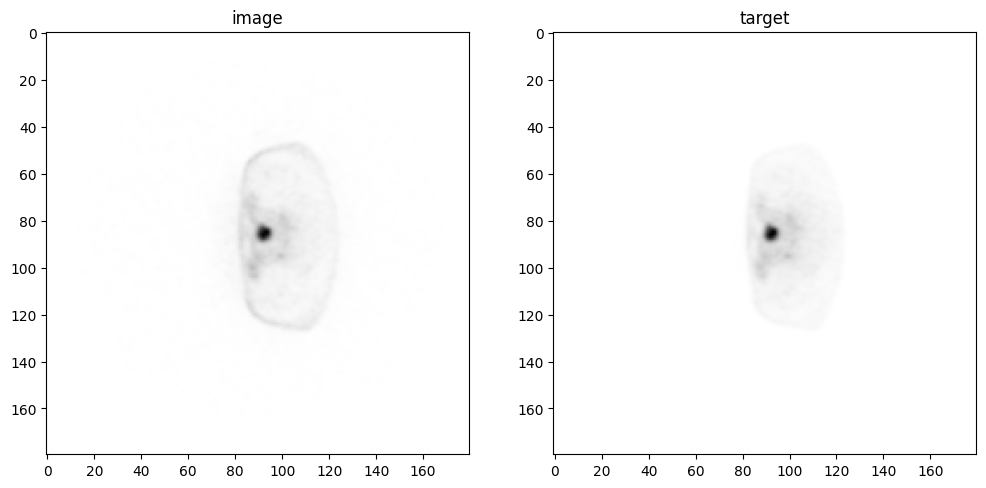

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 100

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="gist_yarg")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n],cmap='gist_yarg' )
plt.show()

In [ ]:
# Load a few sample images from the train_loader and print their sizes
for i, batch_data in enumerate(train_loader):
    images = batch_data["image"]
    print(f"Batch {i} image size: {images.shape}")
    if i == 2:  # Adjust this to inspect more or fewer batches
        break

Batch 0 image size: torch.Size([1, 1, 180, 180, 312])


# **Create Model, Loss, Optimizer**

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [7]:
max_epochs = 50
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
train_losses = []
val_losses = []

In [ ]:


for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, targets = (batch_data["image"].to(device),
                           batch_data["target"].to(device),)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    train_losses.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_targets = (val_data["image"].to(device),
                                           val_data["target"].to(device),)
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_targets).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)
            val_losses.append(val_loss)
            print(f"Validation loss: {val_loss:.4f}")

            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_PET.pth"))
                print("Saved new best metric model")

print(f"Training completed. Best validation loss: {best_metric:.4f} at epoch {best_metric_epoch}")


----------
epoch 1/50
1/10, train_loss: 1.1080
2/10, train_loss: 0.9068
3/10, train_loss: 0.8664
4/10, train_loss: 0.6536
5/10, train_loss: 0.9391
6/10, train_loss: 0.5757
7/10, train_loss: 0.8121
8/10, train_loss: 0.9511
9/10, train_loss: 0.5575
10/10, train_loss: 0.5564
epoch 1 average loss: 0.7927
----------
epoch 2/50
1/10, train_loss: 0.6152
2/10, train_loss: 0.7156
3/10, train_loss: 1.1572
4/10, train_loss: 0.4927
5/10, train_loss: 0.6988
6/10, train_loss: 0.4017
7/10, train_loss: 0.5203
8/10, train_loss: 0.6247
9/10, train_loss: 0.6165
10/10, train_loss: 0.4641
epoch 2 average loss: 0.6307
Validation loss: 0.9327
Saved new best metric model
----------
epoch 3/50
1/10, train_loss: 0.6551
2/10, train_loss: 0.7947
3/10, train_loss: 0.5917
4/10, train_loss: 0.4239
5/10, train_loss: 0.6320
6/10, train_loss: 0.6780
7/10, train_loss: 0.3933
8/10, train_loss: 0.5415
9/10, train_loss: 0.5223
10/10, train_loss: 0.4601
epoch 3 average loss: 0.5693
----------
epoch 4/50
1/10, train_loss: 0.

In [ ]:
import numpy as np
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
plt.figure(figsize=(14, 6))  # Set the size of the figure

# Plotting the training and validation losses
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha = 0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 20))

plt.show()

100%|██████████| 7/7 [01:56<00:00, 16.66s/it]


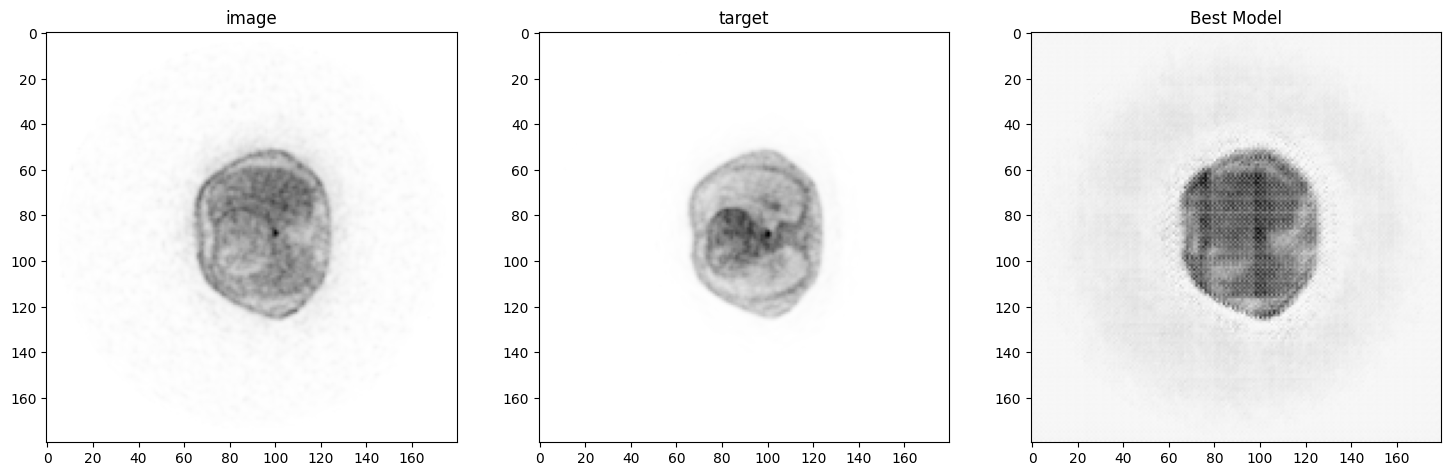

In [10]:
# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70) # using ov= 0.9 best image ever I have.

    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_data["image"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"target")
    plt.imshow(val_data["target"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = val_outputs.detach().cpu()[0, 0, :, :, n]
    plt.imshow(output_slice, cmap="gist_yarg") # "gist_yarg")
    plt.show()


    # Load the best model state for visualization
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_PET.pth")))
model.eval()
roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, val_data in enumerate(val_loader):

        n = 200
        visualize_results(val_data, model, n, f"Best Model")
        if i == 0:
            break




In [ ]:
#         if dice_after > best_eval_dice:
#             best_eval_dice = dice_after
#             if do_save:
#                 # Save best model based on Dice
#                 if pth_best_dice != "":
#                     os.remove(os.path.join(dir_save, pth_best_dice))
#                 pth_best_dice = f"segresnet_kpt_loss_best_dice_{epoch + 1}_{best_eval_dice:.3f}.pth"
#                 torch.save(model.state_dict(), os.path.join(dir_save, pth_best_dice))
#                 print(f"{epoch + 1} | Saving best Dice model: {pth_best_dice}")

#     if do_save:
#         # Save latest model
#         if pth_latest != "":
#             os.remove(os.path.join(dir_save, pth_latest))
#         pth_latest = "segresnet_kpt_loss_latest.pth"
#         torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))


# # learn2reg_nlst_paired_lung_CT notbook